# Data Field Segmentation for Optical Character Recognition (OCR)

**Python** version: 3.7.7   
**OpenCV** version: 4.3.0.36   
**numpy** version: 1.19.2   
**matplotlib** version: 3.2.2   

This Python Jupyter notebook presents some basic image processing techniques useful for the segmentation of data fields into images representing individual characters (e.g. digits).
It uses example data fields extracted from a weather table from the [Bozner Zeitung]( https://digital.tessmann.it/tessmannDigital/Zeitungsarchiv/Monatsuebersicht/Zeitung/2/1842;jsessionid=6134EF3892401068CFB26FE42CBC1E64) and illustrates the deterministic steps required for data field segmentation.

The required libraries are imported:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Some example datafields are loaded and plotted:

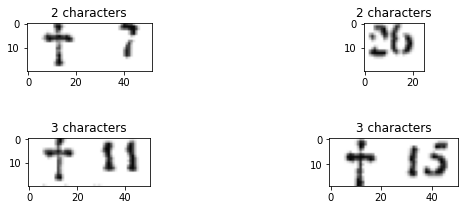

In [2]:
img_rgb_2_0 = cv2.imread("segmentation_data_fields/2_character_number/datafield_5.png")  
img_rgb_2_1 = cv2.imread("segmentation_data_fields/2_character_number/datafield_9.png")  
img_rgb_3_0 = cv2.imread("segmentation_data_fields/3_character_number/datafield_3.png")  
img_rgb_3_1 = cv2.imread("segmentation_data_fields/3_character_number/datafield_56.png")

plt.figure(figsize=(10,3))   
plt.subplot(3,2,1)
plt.imshow(img_rgb_2_0, cmap="gray")
plt.title("2 characters")
plt.subplot(3,2,2)
plt.imshow(img_rgb_2_1, cmap="gray")
plt.title("2 characters")
plt.subplot(3,2,5)
plt.imshow(img_rgb_3_0, cmap="gray")
plt.title("3 characters")
plt.subplot(3,2,6)
plt.imshow(img_rgb_3_1, cmap="gray")
plt.title("3 characters")
plt.show()

## Segmentation of a data field containing 2 characters

The data field to be segmented has to be preprocessed. We need to subject it to thresholding and binarization, in order to extract the relevant contours.

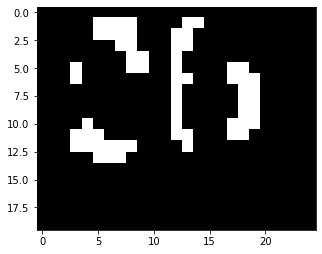

In [3]:
img_rgb = img_rgb_2_1 

gray_img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
ret, thr = cv2.threshold(gray_img, 105, 255, cv2.THRESH_BINARY)
thr_inv= cv2.bitwise_not(thr)

plt.figure(figsize=(5,5))
plt.imshow(thr_inv, cmap="gray")
plt.show()

We extract the x- and y-coordinates of the points that constitute the contours of each structure.

In [4]:
contours, hierarchy = cv2.findContours(thr_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

The variable **contours** contains a list of the coordinates of all contours. We filter this list and obtain the for us relevant x-coordinates of each individual contour, which we save in **list_x_all_cont**. **list_x_all_cont_merged** is a merged version of this list, which we need for the calculation of the center of all contours.

In [5]:
list_x_all_cont = []
for cont in contours: 
    list_x_cont = []
    for n in range(0, len(cont)):
        a = 2*n
        x = np.take(cont, a)
        list_x_cont.append(x)
    list_x_all_cont.append(list_x_cont)
list_x_all_cont_merged = [item for items in list_x_all_cont for item in items]

We determine the minimal and maximal values in **list_x_all_cont_merged** and calculate the center of all contours (**reference_point**).

In [6]:
minimum_x = np.amin(list_x_all_cont_merged)
maximum_x = np.amax(list_x_all_cont_merged)
reference_point = 1/2 * (maximum_x - minimum_x) + minimum_x

In [7]:
reference_point

11.0

For each individual contour we now determine the contour point closest to the center of all contours and save it the list **nearest_list**. For reasons of calculation efficiency we then convert this list into an array (**nearest_array**).

In [8]:
nearest_list = []
for item in list_x_all_cont:
    nearest = item[np.abs(item - reference_point).argmin()] + 1
    nearest_list.append(nearest)

nearest_array = np.asarray(nearest_list)

We then determine the two contour points closest to the center of all contours, one having a value larger and one having a value lower than the center.

In [9]:
try:
    if reference_point > nearest_array.max():
        nearest_bigger = nearest_array.max()
    elif reference_point < nearest_array.min():
        nearest_bigger = nearest_array.min()
    else:
        nearest_bigger = nearest_array[nearest_array >= reference_point].min()
except:
    pass

try: 
    if reference_point < nearest_array.min():
        nearest_smaller = nearest_array.min()
    elif reference_point > nearest_array.max():
        nearest_smaller = nearest_array.max()
    else:
        nearest_smaller = nearest_array[nearest_array <= reference_point].max()  
except:
    pass

The center of these two points (**cutting_x**) is the location that we use for image segmentation.

In [10]:
cutting_x = np.mean([nearest_bigger, nearest_smaller])

We finally perform the image segmentation.

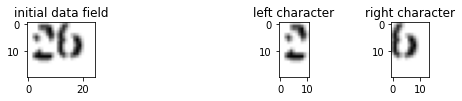

In [11]:
y = 0
x = 0
h = len(img_rgb)
w = int(cutting_x)        
left_character = img_rgb[y:y+h, x:x+w]

y = 0
x = int(cutting_x)
h = len(img_rgb)
w = img_rgb.shape[1] - x        
right_character = img_rgb[y:y+h, x:x+w]

plt.figure(figsize=(8,1))  
plt.subplot(1,4,1)
plt.imshow(img_rgb, cmap="gray")
plt.title("initial data field")
plt.subplot(1,4,3)
plt.imshow(left_character, cmap="gray")
plt.title("left character")
plt.subplot(1,4,4)
plt.imshow(right_character, cmap="gray")
plt.title("right character")
plt.show()

## Refactoring the code

In order to be able to efficiently use the segmentation algorithm we just developped, we bring it together in a function:

In [12]:
def two_character_segmentation_symmetric (img_rgb):
    
    gray_img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    ret, thr = cv2.threshold(gray_img, 105, 255, cv2.THRESH_BINARY)
    thr_inv= cv2.bitwise_not(thr)
    
    contours, hierarchy = cv2.findContours(thr_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    list_x_all_cont = []
    for cont in contours: 
        list_x_cont = []
        for n in range(0, len(cont)):
            a = 2*n
            x = np.take(cont, a)
            list_x_cont.append(x)
        list_x_all_cont.append(list_x_cont)
    list_x_all_cont_merged = [item for items in list_x_all_cont for item in items]
    
    minimum_x = np.amin(list_x_all_cont_merged)
    maximum_x = np.amax(list_x_all_cont_merged)
    reference_point = 1/2 * (maximum_x - minimum_x) + minimum_x
    
    nearest_list = []
    for item in list_x_all_cont:
        nearest = item[np.abs(item - reference_point).argmin()] + 1
        nearest_list.append(nearest)

    nearest_array = np.asarray(nearest_list)
    
    try:
        if reference_point > nearest_array.max():
            nearest_bigger = nearest_array.max()
        elif reference_point < nearest_array.min():
            nearest_bigger = nearest_array.min()
        else:
            nearest_bigger = nearest_array[nearest_array >= reference_point].min()
    except:
        pass

    try: 
        if reference_point < nearest_array.min():
            nearest_smaller = nearest_array.min()
        elif reference_point > nearest_array.max():
            nearest_smaller = nearest_array.max()
        else:
            nearest_smaller = nearest_array[nearest_array <= reference_point].max()  
    except:
        pass
    
    cutting_x = np.mean([nearest_bigger, nearest_smaller])
    
    y = 0
    x = 0
    h = len(img_rgb)
    w = int(cutting_x)        
    left_character = img_rgb[y:y+h, x:x+w]

    y = 0
    x = int(cutting_x)
    h = len(img_rgb)
    w = img_rgb.shape[1] - x        
    right_character = img_rgb[y:y+h, x:x+w]
    
    return left_character, right_character

We check, whether the refactoring worked correctly:

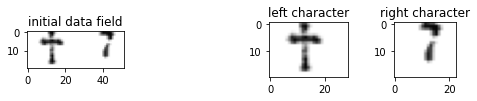

In [13]:
segmented_symmetric = two_character_segmentation_symmetric(img_rgb_2_0)

plt.figure(figsize=(8,1))  
plt.subplot(1,4,1)
plt.imshow(img_rgb_2_0, cmap="gray")
plt.title("initial data field")
plt.subplot(1,4,3)
plt.imshow(segmented_symmetric[0], cmap="gray")
plt.title("left character")
plt.subplot(1,4,4)
plt.imshow(segmented_symmetric[1], cmap="gray")
plt.title("right character")
plt.show()

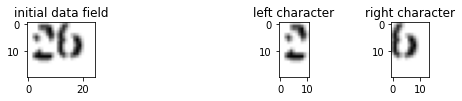

In [14]:
segmented_symmetric = two_character_segmentation_symmetric(img_rgb_2_1)

plt.figure(figsize=(8,1))  
plt.subplot(1,4,1)
plt.imshow(img_rgb_2_1, cmap="gray")
plt.title("initial data field")
plt.subplot(1,4,3)
plt.imshow(segmented_symmetric[0], cmap="gray")
plt.title("left character")
plt.subplot(1,4,4)
plt.imshow(segmented_symmetric[1], cmap="gray")
plt.title("right character")
plt.show()

As we can see, the code we refactored works nicely.

## Segmentation of a data field containing 3 characters

In order to segment a data field containing 3 characters, we use the approach we just developped in a repetitive way. First, we segment the data field into 2 new data fields, one containing 1 character, the other containing 2 characters. After that we segment the data field containing 2 characters again, just the way we did it above.

The code for the segmentation of a 3 character data field into a data field containing 1 character and a data field containing 2 characters is nearly the same as above, with only one different codeline:  
instead of    
**reference_point = 1/2 * (maximum_x - minimum_x) + minimum_x**  
we use     
**reference_point = 1/3 * (maximum_x - minimum_x) + minimum_x**.  

We call this modified algorithm **two_character_segmentation_asymmetric**.

In [15]:
def two_character_segmentation_asymmetric (img_rgb):
    
    gray_img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    ret, thr = cv2.threshold(gray_img, 105, 255, cv2.THRESH_BINARY)
    thr_inv= cv2.bitwise_not(thr)
    
    contours, hierarchy = cv2.findContours(thr_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    list_x_all_cont = []
    for cont in contours: 
        list_x_cont = []
        for n in range(0, len(cont)):
            a = 2*n
            x = np.take(cont, a)
            list_x_cont.append(x)
        list_x_all_cont.append(list_x_cont)
    list_x_all_cont_merged = [item for items in list_x_all_cont for item in items]
    
    minimum_x = np.amin(list_x_all_cont_merged)
    maximum_x = np.amax(list_x_all_cont_merged)
    reference_point = 1/3 * (maximum_x - minimum_x) + minimum_x
    
    nearest_list = []
    for item in list_x_all_cont:
        nearest = item[np.abs(item - reference_point).argmin()] + 1
        nearest_list.append(nearest)

    nearest_array = np.asarray(nearest_list)
    
    try:
        if reference_point > nearest_array.max():
            nearest_bigger = nearest_array.max()
        elif reference_point < nearest_array.min():
            nearest_bigger = nearest_array.min()
        else:
            nearest_bigger = nearest_array[nearest_array >= reference_point].min()
    except:
        pass

    try: 
        if reference_point < nearest_array.min():
            nearest_smaller = nearest_array.min()
        elif reference_point > nearest_array.max():
            nearest_smaller = nearest_array.max()
        else:
            nearest_smaller = nearest_array[nearest_array <= reference_point].max()  
    except:
        pass
    
    cutting_x = np.mean([nearest_bigger, nearest_smaller])
    
    y = 0
    x = 0
    h = len(img_rgb)
    w = int(cutting_x)        
    left_character = img_rgb[y:y+h, x:x+w]

    y = 0
    x = int(cutting_x)
    h = len(img_rgb)
    w = img_rgb.shape[1] - x        
    right_character = img_rgb[y:y+h, x:x+w]
    
    return left_character, right_character

Now we can perform the asymmetric segmentation, which is the first step for the segmentation of a 3 character data field.

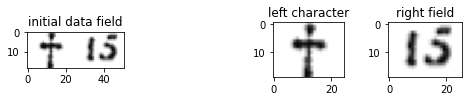

In [16]:
segmented_asymmetric = two_character_segmentation_asymmetric(img_rgb_3_1)

plt.figure(figsize=(8,1))  
plt.subplot(1,4,1)
plt.imshow(img_rgb_3_1, cmap="gray")
plt.title("initial data field")
plt.subplot(1,4,3)
plt.imshow(segmented_asymmetric[0], cmap="gray")
plt.title("left character")
plt.subplot(1,4,4)
plt.imshow(segmented_asymmetric[1], cmap="gray")
plt.title("right field")
plt.show()

Using the **two_character_segmentation_symmetric** - function we segment the right field and obtain the individual characters:

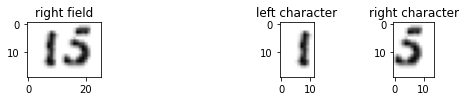

In [17]:
segmented_symmetric_rf = two_character_segmentation_symmetric(segmented_asymmetric[1])
plt.figure(figsize=(8,1))  
plt.subplot(1,4,1)
plt.imshow(segmented_asymmetric[1], cmap="gray")
plt.title("right field")
plt.subplot(1,4,3)
plt.imshow(segmented_symmetric_rf[0], cmap="gray")
plt.title("left character")
plt.subplot(1,4,4)
plt.imshow(segmented_symmetric_rf[1], cmap="gray")
plt.title("right character")
plt.show()

And here the result of the 2 segmentation steps put together:

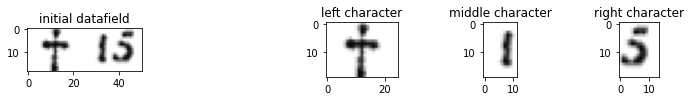

In [18]:
left_character = two_character_segmentation_asymmetric(img_rgb_3_1)[0]
right_field = two_character_segmentation_asymmetric(img_rgb_3_1)[1]

middle_character = two_character_segmentation_symmetric(right_field)[0]
right_character = two_character_segmentation_symmetric(right_field)[1]

plt.figure(figsize=(12,1))  
plt.subplot(1,5,1)
plt.imshow(img_rgb_3_1, cmap="gray")
plt.title("initial datafield")
plt.subplot(1,5,3)
plt.imshow(left_character, cmap="gray")
plt.title("left character")
plt.subplot(1,5,4)
plt.imshow(middle_character, cmap="gray")
plt.title("middle character")
plt.subplot(1,5,5)
plt.imshow(right_character, cmap="gray")
plt.title("right character")
plt.show()

## Size normalization of character images from segmented data fields

Machine-learning based optical character recognition requires standardized image formats. We can standardize the size of the character images we obtained from the data field segmentation by cropping the images around their contours and placing these cropped images in the center of new blank images of a defined format. 

In order to do so, we first need to perform the image preprocessing steps described above and to extract the contours:

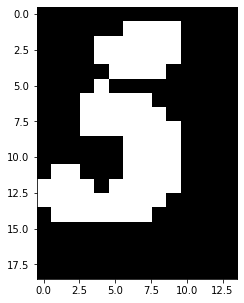

In [19]:
img_rgb = right_character

gray_img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
# please be aware that the thresholding parameter (220) is different from the one used above
ret, thr = cv2.threshold(gray_img, 220, 255, cv2.THRESH_BINARY)
thr_inv= cv2.bitwise_not(thr)

plt.figure(figsize=(5,5))
plt.imshow(thr_inv, cmap="gray")
plt.show()

We extract the left and right margins of the contours (**min_largest_cont_x** and **max_largest_cont_x**):

In [20]:
contours, hierarchy = cv2.findContours(thr_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_cont = max(contours, key=len)

largest_cont_x = [i[0][0] for i in largest_cont]
median_largest_cont_x = np.median(largest_cont_x)
min_largest_cont_x = np.amin(largest_cont_x)
max_largest_cont_x = np.amax(largest_cont_x)

In [21]:
min_largest_cont_x

0

In [22]:
max_largest_cont_x

9

With these margins we can crop the image:

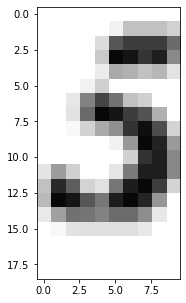

In [23]:
y = 0
x = int(min_largest_cont_x)
h = int(img_rgb.shape[0])
w = int(max_largest_cont_x - min_largest_cont_x) + 1    
cropped = img_rgb[y:y+h, x:x+w]

plt.figure(figsize=(5,5))
plt.imshow(cropped, cmap="gray")
plt.show()

We finally generate a blank image of 25x25 pixels and place the cropped image in its center:

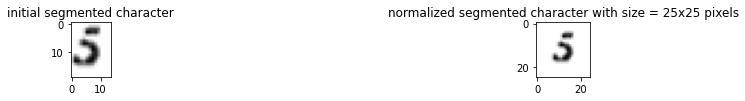

In [24]:
# Code reference:
# https://stackoverflow.com/questions/14063070/overlay-a-smaller-image-on-a-larger-image-python-opencv

height, width = (25, 25)
blank_image = np.full((height, width, 3), 255, dtype=int)

x_offset = int((width  - cropped.shape[1])/2)
y_offset = int((height - cropped.shape[0])/2)

blank_image[y_offset:y_offset + cropped.shape[0], x_offset:x_offset + cropped.shape[1]] = cropped

plt.figure(figsize=(12,1))  
plt.subplot(1,3,1)
plt.imshow(img_rgb, cmap="gray")
plt.title("initial segmented character")
plt.subplot(1,3,3)
plt.imshow(blank_image, cmap="gray")
plt.title("normalized segmented character with size = " + str(height) + "x" + str(width) + " pixels")
plt.show()